# Data Access

Taken from a notebook created by Tyler Sutterly for the 2022 ICESat-2 Hackweek, put on by the e-science institute at UW.  

Install new version of sliderule:  
"But if you do a **git pull** in your sliderule-python repo and then to a **python setup.py install**, it should resolve the issue."  
https://icesat-2sliderule.slack.com/archives/CTW2ESWFP/p1638199956016000

In [1]:
import os
import geopandas as gpd
import ipyleaflet
import ipywidgets as widgets
import logging
#import panel as pn
#pn.extension()
import matplotlib.lines
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
from shapely.geometry import Polygon
import warnings
# grimp and nisar functions
#import grimpfunc as grimp
#import nisardev as nisar
# sliderule functions
import sliderule.icesat2
import sliderule.io
import sliderule.ipysliderule
import pandas as pd
from datetime import datetime
import pickle
# register progress bar and set workers
#ProgressBar().register()
#dask.config.set(num_workers=2)
# turn off warnings for demo
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

In [3]:
# set the url for the sliderule service
# set the logging level
sliderule.icesat2.init("icesat2sliderule.org", loglevel=logging.WARNING)

In [6]:
sliderule.ipysliderule?

Type:        module
String form: <module 'sliderule.ipysliderule' from '/Users/Hannah/opt/miniconda3/envs/sliderule/lib/python3.8/site-packages/sliderule-1.4.2-py3.8.egg/sliderule/ipysliderule.py'>
File:        ~/opt/miniconda3/envs/sliderule/lib/python3.8/site-packages/sliderule-1.4.2-py3.8.egg/sliderule/ipysliderule.py
Docstring:   <no docstring>


In [9]:
SRwidgets.spread?

Type:           FloatSlider
String form:    FloatSlider(value=20.0, continuous_update=False, description='Spread:', description_tooltip='Spread: minimum along track spread for valid segments in meters', min=1.0, readout_format='0.1f')
File:           ~/opt/miniconda3/envs/sliderule/lib/python3.8/site-packages/ipywidgets/widgets/widget_float.py
Docstring:     
Slider/trackbar of floating values with the specified range.

Parameters
----------
value : float
    position of the slider
min : float
    minimal position of the slider
max : float
    maximal position of the slider
step : float
    step of the trackbar
description : str
    name of the slider
orientation : {'horizontal', 'vertical'}
    default is 'horizontal', orientation of the slider
readout : {True, False}
    default is True, display the current value of the slider next to it
readout_format : str
    default is '.2f', specifier for the format function used to represent
    slider value for human consumption, modeled after

In [8]:
# display widgets for setting SlideRule parameters
SRwidgets = sliderule.ipysliderule.widgets()
# show widgets
widgets.VBox([
    SRwidgets.asset,
    SRwidgets.release,
    SRwidgets.surface_type,
    SRwidgets.length,
    SRwidgets.step,
    SRwidgets.confidence,
    SRwidgets.land_class,
    SRwidgets.iteration,
    SRwidgets.spread,
    SRwidgets.count,
    SRwidgets.window,
    SRwidgets.sigma
])

In [48]:
widgets.VBox([SRwidgets.projection, SRwidgets.layers])

In [55]:
# should use the pickle version once I create it.
methow = '../../data/site_outlines/methow_outline_4326.pkl'

In [56]:
polygon_gdf = pickle.load(open(methow, 'rb'))
polygon_gdf.head()

,fn,date,geometry
3,./datasetsA/methow_basin_2018/dtm/raw/methow_b...,2018,"POLYGON ((-120.33042 48.80903, -120.33042 48.8..."


<AxesSubplot:>

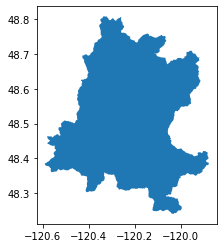

In [57]:
polygon_gdf.plot()

In [58]:
polygon_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [59]:
# create ipyleaflet map in specified projection
m = sliderule.ipysliderule.leaflet(SRwidgets.projection.value)
m.add_layer(layers=SRwidgets.layers.value)

# Comment this section out if you want to draw your own polygon!
# ---
#box = shapely.geometry.Polygon([(-108.3,38.9), (-108.0,38.9), (-108.0,39.1), (-108.3, 39.1)])
#geobox = gpd.GeoDataFrame(geometry=[box], crs='EPSG:4326')
default_polygon = sliderule.io.from_geodataframe(polygon_gdf)
geodata = ipyleaflet.GeoData(geo_dataframe=polygon_gdf)
m.map.add_layer(geodata)
# ---

m.map

Map(center=[39, -108], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [60]:
#%%time
# sliderule asset and data release
asset = SRwidgets.asset.value
release = SRwidgets.release.value

# build sliderule parameters using latest values from widget
params = {
    # surface type: 0-land, 1-ocean, 2-sea ice, 3-land ice, 4-inland water
    "srt": SRwidgets.surface_type.index,
    # length of ATL06-SR segment in meters
    "len": SRwidgets.length.value,
    # step distance for successive ATL06-SR segments in meters
    "res": SRwidgets.step.value,
    # confidence level for PE selection
    "cnf": SRwidgets.confidence.value,
    # ATL08 land surface classifications
    "atl08_class": list(SRwidgets.land_class.value),
    # maximum iterations, not including initial least-squares-fit selection
    "maxi": SRwidgets.iteration.value,
    # minimum along track spread
    "ats": SRwidgets.spread.value,
    # minimum PE count
    "cnt": SRwidgets.count.value,
    # minimum height of PE window in meters
    "H_min_win": SRwidgets.window.value,
    # maximum robust dispersion in meters
    "sigma_r_max": SRwidgets.sigma.value
}

region = sliderule.icesat2.toregion(polygon_gdf)
params["poly"] = region["poly"]   # will always be the convex hull of the polygon
params["raster"] = region["raster"]   # raster will include all vertices, including holes. This is more processing, but is only an issue with very large requests.
gdf = sliderule.icesat2.atl06p(params, asset, version=release)

In [61]:
print(f'Returned {gdf.shape[0]} records')
gdf.head()

Returned 148886 records


,pflags,h_mean,dh_fit_dy,spot,w_surface_window_final,h_sigma,distance,segment_id,dh_fit_dx,rgt,cycle,delta_time,gt,n_fit_photons,rms_misfit,geometry
time,,,,,,,,,,,,,,,,
2018-11-09 22:09:43.662511060,0,774.110259,0.0,5,9.386548,0.079705,5.382001e+06,268398,0.367318,646,1,2.703658e+07,20,41,0.506044,POINT (-120.00053 48.33917)
2018-11-09 22:09:43.789049908,0,919.941824,0.0,5,3.000000,0.050617,5.382903e+06,268443,0.028568,646,1,2.703658e+07,20,42,0.305572,POINT (-120.00167 48.34723)
2018-11-09 22:09:43.794872008,0,918.460968,0.0,5,3.029108,0.046853,5.382943e+06,268445,-0.116342,646,1,2.703658e+07,20,31,0.240537,POINT (-120.00172 48.34760)
2018-11-09 22:09:43.797684372,0,916.399163,0.0,5,3.000000,0.059160,5.382963e+06,268446,-0.091024,646,1,2.703658e+07,20,39,0.325805,POINT (-120.00174 48.34778)
2018-11-09 22:09:43.800494952,0,915.721672,0.0,5,3.000000,0.038990,5.382983e+06,268447,-0.027886,646,1,2.703658e+07,20,40,0.245902,POINT (-120.00177 48.34796)


In [62]:
out_fn = '../../data/methow_all_sr-atl06-10182022.pkl'

with open(out_fn, 'wb') as f:
    pickle.dump(gdf, f)

#### Create plots for a single track

In [ ]:
# selection for reference ground track
RGTs = [str(int(x)) for x in gdf.rgt.unique()]
SRwidgets.rgt = widgets.Dropdown(
    options=RGTs,
    value=RGTs[1], # You can change this with the pull-down widget below!
    description="RGT:",
    description_tooltip="RGT: Reference Ground Track to plot",
    disabled=False
)

# selection for ground track
ground_track_options = ["gt1l","gt1r","gt2l","gt2r","gt3l","gt3r"]
SRwidgets.ground_track = widgets.Dropdown(
    options=ground_track_options,
    value='gt1l',
    description="Track:",
    description_tooltip="Track: Ground Track to plot",
    disabled=False
)      
widgets.VBox([
    SRwidgets.rgt,
    SRwidgets.ground_track,
])